# Milestone 3: Feature Engineering + Hyperparameter Tuning

## Project notebook


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import os
import glob
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, lit, lead, lag, avg, stddev, min, max, concat_ws
from pyspark.sql.window import Window
from pyspark.sql.functions import year, col, min as spark_min, max as spark_max
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType, IntegerType
from pyspark.sql.functions import sqrt, avg, lead, col, expr, to_date, year, mean, log, row_number
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, PCA
from pyspark.sql.functions import abs as spark_abs


In [ ]:
import sys
print(sys.executable)
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

c:\Users\10648\miniconda3\envs\spark\python.exe


In [ ]:
# Initialize PySpark session with hostname configuration
spark = SparkSession.builder \
    .master("local[10]") \
    .appName("Stock Price Forecast") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

In [25]:
# Add this after creating the Spark session
spark.sparkContext.setLogLevel("ERROR")  # Only show ERROR level logs, hide WARN

In [4]:
ROOT_DIR = "./"

## Read the data

In [5]:
# Define paths to data directories
csv_path = os.path.join(ROOT_DIR, "data/stock_market_data/forbes2000/csv/")
json_path = os.path.join(ROOT_DIR, "data/stock_market_data/forbes2000/json/")

# Get a list of all available stock files
csv_files = glob.glob(os.path.join(csv_path, "*.csv"))
json_files = glob.glob(os.path.join(json_path, "*.json"))

print(f"Found {len(csv_files)} CSV files and {len(json_files)} JSON files")

# Display some sample stocks
print("Sample stocks:")
print([os.path.basename(file).split('.')[0] for file in csv_files[:10]])

Found 1076 CSV files and 1170 JSON files
Sample stocks:
['CSCO', 'CSUAY', 'MQBKY', 'AIPUY', 'ZURVY', 'PWCDF', 'SMTUF', 'BCMXY', 'JMPLY', 'KOTMY']


#### Raw Features and Derived Features

The rew features from the CSV dataset will be used directly for the future development:

- Date: Trading date

- Low: Lowest price of the day

- Open: Opening price

- Volume: Number of shares traded

- High: Highest price of the day

- Close: Closing price

- Adjusted Close: Closing price adjusted for splits and dividends

Some features from the JSON dataset:

- Meta data: Currency, symbol, exchange, instrument type, etc.

- Trading periods information

- More granular timestamp series

- Additional price history details

In [6]:
def extract_metadata_features(json_file):
    """Extract valuable metadata features from JSON file"""
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading JSON file {json_file}: {e}")
        return None
    
    try:
        ticker = os.path.basename(json_file).split('.')[0]
        meta = data['chart']['result'][0]['meta']
        
        # Extract valuable metadata fields
        metadata = {
            'Symbol': ticker,
            'Currency': meta.get('currency'),
            'Exchange': meta.get('exchangeName'),
            'InstrumentType': meta.get('instrumentType'),
            'FirstTradeDate': meta.get('firstTradeDate'),
            'RegularMarketPrice': meta.get('regularMarketPrice'),
            'ChartPreviousClose': meta.get('chartPreviousClose'),
            'TimeZone': meta.get('timezone')
        }
        
            
        return metadata
    except (KeyError, IndexError) as e:
        print(f"Error extracting metadata from {json_file}: {e}")
        return None

In [7]:
def clean_and_handle_missing_values_improved(df):
    """
    Clean data and handle missing values with improved approach
    
    Args:
        df: PySpark DataFrame with features
    
    Returns:
        Cleaned PySpark DataFrame
    """
    
    
    # Count rows before cleaning
    initial_count = df.count()
    print(f"Initial row count: {initial_count}")
    
    # Check null counts in essential columns
    null_counts = {}
    for column in ["Date", "Close", "Open", "Symbol"]:
        if column in df.columns:
            null_count = df.filter(col(column).isNull()).count()
            null_counts[column] = null_count
    
    print("Null counts in essential columns:")
    for col_name, count in null_counts.items():
        print(f"- {col_name}: {count} nulls ({count/initial_count:.2%})")
    
    # Remove rows with null dates or missing basic price data
    cleaned_df = df.filter(
        col("Date").isNotNull() &
        col("Close").isNotNull() &
        col("Open").isNotNull()
    )
    
    # Count rows after removing null essential data
    basic_cleaned_count = cleaned_df.count()
    print(f"Rows after basic cleaning: {basic_cleaned_count} ({basic_cleaned_count/initial_count:.2%} of original)")
    
    # Get list of numeric columns for different treatment strategies
    price_cols = ["Open", "High", "Low", "Close", "Volume", "Adjusted Close"]
    derived_cols = [f.name for f in cleaned_df.schema.fields 
                   if isinstance(f.dataType, (DoubleType, IntegerType)) 
                   and f.name not in price_cols
                   and not f.name.startswith("Target_")]
    
    target_cols = [f.name for f in cleaned_df.schema.fields 
                  if f.name.startswith("Target_")]
    
    # Identify categorical and metadata columns
    categorical_cols = ["currency", "exchange", "instrumentType", "timezone"]
    
    # Check for null values in these column groups
    print("\nNull value counts after basic cleaning:")
    for col_type, columns in [("Price", price_cols), 
                             ("Derived", derived_cols[:5] + ["..."]), 
                             ("Target", target_cols[:5] + ["..."]),
                             ("Categorical", categorical_cols)]:
        for col_name in columns:
            if col_name != "...":
                if col_name in cleaned_df.columns:
                    null_count = cleaned_df.filter(col(col_name).isNull()).count()
                    print(f"- {col_type}: {col_name}: {null_count} nulls ({null_count/basic_cleaned_count:.2%})")
    
    # Handle null values in price columns (more strict)
    # For most price data we require it to be present
    for col_name in price_cols:
        if col_name in cleaned_df.columns:
            cleaned_df = cleaned_df.filter(col(col_name).isNotNull())
    
    # For derived metrics, fill with appropriate defaults
    # Fill zeros for ratios, moving averages and other metrics that are calculated
    for col_name in derived_cols:
        if col_name in cleaned_df.columns:
            cleaned_df = cleaned_df.withColumn(
                col_name, 
                when(col(col_name).isNull(), 0).otherwise(col(col_name))
            )
    
    # Handle categorical columns with appropriate defaults
    if "currency" in cleaned_df.columns:
        cleaned_df = cleaned_df.withColumn(
            "currency", 
            when(col("currency").isNull(), "USD").otherwise(col("currency"))
        )
    
    if "exchange" in cleaned_df.columns:
        cleaned_df = cleaned_df.withColumn(
            "exchange", 
            # USE NYSE as default because it is the most common exchange in the dataset
            when(col("exchange").isNull(), "NYSE").otherwise(col("exchange"))
        )
    
    if "instrumentType" in cleaned_df.columns:
        cleaned_df = cleaned_df.withColumn(
            "instrumentType", 
            when(col("instrumentType").isNull(), "EQUITY").otherwise(col("instrumentType"))
        )
    
    # Special handling for timezone data
    if "timezone" in cleaned_df.columns:
        # Standardize timezone format and fill missing with default
        cleaned_df = cleaned_df.withColumn(
            "timezone", 
            when(col("timezone").isNull(), "EST")  # Default US market timezone
            .otherwise(col("timezone"))
        )
        
    
    
    # Process categorical columns with StringIndexer and OneHotEncoder
    indexed_cols = []
    
    print("\nEncoding categorical features for ML:")
    print(f"- Features to encode: {categorical_cols}")
    
    # Create and apply string indexers for each categorical column
    for cat_col in categorical_cols:
        # Create a new indexed column name
        indexed_col = f"{cat_col}_indexed"
        indexed_cols.append(indexed_col)
        
        # Create and fit the string indexer
        indexer = StringIndexer(
            inputCol=cat_col, 
            outputCol=indexed_col,
            handleInvalid="keep"  # Options: keep, skip, error
        )
        
        # Apply the indexer
        cleaned_df = indexer.fit(cleaned_df).transform(cleaned_df)
        
        
    encoder = OneHotEncoder(
        inputCols=indexed_cols,
        outputCols=[f"{col.replace('_indexed', '')}_vec" for col in indexed_cols],
        dropLast=True
    )
        
    # Apply the encoder
    cleaned_df = encoder.fit(cleaned_df).transform(cleaned_df)
        
    # Add encoded columns to track them
    encoded_cols = [f"{col.replace('_indexed', '')}_vec" for col in indexed_cols]
    
    # For target columns, we need to decide whether to drop rows or impute
    # Here we'll drop rows where required target columns are missing
    required_targets = ["Target_Direction_1d", "Target_Return_1d"]  # Example
    for col_name in required_targets:
        if col_name in cleaned_df.columns:
            cleaned_df = cleaned_df.filter(col(col_name).isNotNull())
    
    
    # Count rows after all cleaning
    final_count = cleaned_df.count()
    print(f"Final row count: {final_count} ({final_count/initial_count:.2%} of original)")
    
    # Record the list of all ML-ready features in a new column
    numeric_features = price_cols + derived_cols
    numeric_features = [c for c in numeric_features if c in cleaned_df.columns]
    
    # Store this list as metadata in the DataFrame properties for future reference
    # cleaned_df = cleaned_df.withColumn("_ML_FEATURES", lit(",".join(all_ml_features)))
    
    return cleaned_df

### Target variables for stock price forecasting

For stock price forecasting, we need to carefully select our target variables based on both theoretical considerations and practical applications. Here are the refined target variables we'll use:

1. **Next-Day Return** (Target_Return_1d)

   - Definition: The percentage change in price from today's close to tomorrow's close

   - Formula: $(Close_{t+1} - Close_t) / Close_t$

   - Rationale: Returns are stationary and comparable across different stocks, making them better prediction targets than raw prices

2. **Next-Week Return** (Target_Return_1d)

   - Definition: The percentage change in price from today's close to next week's close

   - Formula: $(Close_{t+7} - Close_t) / Close_t$

   - Rationale: Returns are stationary and comparable across different stocks, making them better prediction targets than raw prices

2. **Next-Month Return** (Target_Return_1d)

   - Definition: The percentage change in price from today's close to next month's close

   - Formula: $(Close_{t+30} - Close_t) / Close_t$

   - Rationale: Returns are stationary and comparable across different stocks, making them better prediction targets than raw prices


For the three target, each has its own meaning and representation and we shall discover the usage and result of different evaluation metric.

In [8]:
def create_comprehensive_targets(df):
    """Create comprehensive set of target variables"""
    # Define window specifications for future calculations
    window_by_stock = Window.partitionBy("Symbol").orderBy("Date")
    
    df = df.withColumn(f"Target_FutureClose_1d", lead("Close", 1).over(window_by_stock))

    df = df.withColumn(f"Target_Return_1d", (col(f"Target_FutureClose_1d") - col("Close")) / col("Close"))

    df = df.withColumn(f"Target_Direction_1d", when(col(f"Target_Return_1d") > 0, 1).otherwise(0))

    
    return df

In [9]:
def add_technical_features(df):
    """
    Add technical indicators and features to the stock data DataFrame
    
    Args:
        df: PySpark DataFrame with stock price data
    
    Returns:
        PySpark DataFrame with additional features
    """
    # Drop the rows if Date is null
    df = df.filter(col("Date").isNotNull())

    # Define window specifications for different periods
    window_by_stock = Window.partitionBy("Symbol").orderBy("Date")
    window_7d = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-7, 0)
    window_14d = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-14, 0)
    window_30d = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-30, 0)
    window_90d = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-90, 0)
    
    # Add basic features
    enhanced_df = df \
        .withColumn("PrevClose", lag("Close", 1).over(window_by_stock)) \
        .withColumn("Return", (col("Close") - col("PrevClose")) / col("PrevClose")) \
        .withColumn("LogReturn", log(col("Close") / col("PrevClose")))
    
    # Add moving averages
    enhanced_df = enhanced_df \
        .withColumn("MA7", avg("Close").over(window_7d)) \
        .withColumn("MA30", avg("Close").over(window_30d)) \
        .withColumn("MA90", avg("Close").over(window_90d))
    
    # Add price relative to moving averages
    enhanced_df = enhanced_df \
        .withColumn("Close_MA7_Ratio", col("Close") / col("MA7")) \
        .withColumn("Close_MA30_Ratio", col("Close") / col("MA30")) \
        .withColumn("MA7_MA30_Ratio", col("MA7") / col("MA30"))
    
    # Add volatility indicators
    enhanced_df = enhanced_df \
        .withColumn("STD7", stddev("Close").over(window_7d)) \
        .withColumn("STD30", stddev("Close").over(window_30d)) \
        .withColumn("VolatilityRatio", col("STD7") / col("STD30"))
    
    # Add range and momentum indicators
    enhanced_df = enhanced_df \
        .withColumn("HighLowRange", col("High") - col("Low")) \
        .withColumn("HighLowRangeRatio", col("HighLowRange") / col("Close")) \
        .withColumn("CloseDelta", col("Close") - col("Open")) \
        .withColumn("CloseOpenRatio", col("Close") / col("Open"))
    
    # Add volume indicators
    enhanced_df = enhanced_df \
        .withColumn("VolumeDelta", col("Volume") - lag("Volume", 1).over(window_by_stock)) \
        .withColumn("VolumeMA7", avg("Volume").over(window_7d)) \
        .withColumn("VolumeMA30", avg("Volume").over(window_30d)) \
        .withColumn("RelativeVolume", col("Volume") / col("VolumeMA30")) \
        .withColumn("MoneyFlow", col("Volume") * (col("Close") - col("Open")))
    
    # Add high/low indicators
    enhanced_df = enhanced_df \
        .withColumn("MaxHigh7", max("High").over(window_7d)) \
        .withColumn("MinLow7", min("Low").over(window_7d)) \
        .withColumn("MaxHigh30", max("High").over(window_30d)) \
        .withColumn("MinLow30", min("Low").over(window_30d))
    
    # Calculate positions relative to ranges
    enhanced_df = enhanced_df \
        .withColumn("CloseToHighPos7", (col("Close") - col("MinLow7")) / (col("MaxHigh7") - col("MinLow7"))) \
        .withColumn("CloseToHighPos30", (col("Close") - col("MinLow30")) / (col("MaxHigh30") - col("MinLow30")))
    
    # Add RSI (14-day)
    enhanced_df = enhanced_df \
        .withColumn("UpMove", when(col("Close") > lag("Close", 1).over(window_by_stock), 
                                  col("Close") - lag("Close", 1).over(window_by_stock)).otherwise(0)) \
        .withColumn("DownMove", when(col("Close") < lag("Close", 1).over(window_by_stock), 
                                    lag("Close", 1).over(window_by_stock) - col("Close")).otherwise(0)) \
        .withColumn("AvgUp14", avg("UpMove").over(window_14d)) \
        .withColumn("AvgDown14", avg("DownMove").over(window_14d)) \
        .withColumn("RS", col("AvgUp14") / when(col("AvgDown14") == 0, 0.001).otherwise(col("AvgDown14"))) \
        .withColumn("RSI", 100 - (100 / (1 + col("RS"))))
    
    ################
    # NEW FEATURES
    ################

    # Add MACD (Moving Average Convergence Divergence)
    enhanced_df = enhanced_df \
        .withColumn("EMA12", avg(col("Close")).over(Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-12, 0))) \
        .withColumn("EMA26", avg(col("Close")).over(Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-26, 0))) \
        .withColumn("MACD", col("EMA12") - col("EMA26")) \
        .withColumn("SignalLine", avg(col("MACD")).over(Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-9, 0))) \
        .withColumn("MACDHistogram", col("MACD") - col("SignalLine"))

    # Add Rate of Change (ROC)
    enhanced_df = enhanced_df \
        .withColumn("ROC5", (col("Close") - lag("Close", 5).over(window_by_stock)) / lag("Close", 5).over(window_by_stock) * 100) \
        .withColumn("ROC10", (col("Close") - lag("Close", 10).over(window_by_stock)) / lag("Close", 10).over(window_by_stock) * 100) \
        .withColumn("ROC20", (col("Close") - lag("Close", 20).over(window_by_stock)) / lag("Close", 20).over(window_by_stock) * 100)

    # Add Bollinger Bands
    enhanced_df = enhanced_df \
        .withColumn("MA20", avg("Close").over(Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-20, 0))) \
        .withColumn("StdDev20", stddev("Close").over(Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-20, 0))) \
        .withColumn("UpperBand", col("MA20") + col("StdDev20") * 2) \
        .withColumn("LowerBand", col("MA20") - col("StdDev20") * 2) \
        .withColumn("PercentB", (col("Close") - col("LowerBand")) / (col("UpperBand") - col("LowerBand")))


    # End of new features
    return enhanced_df

In [10]:
def process_full_dataset(csv_dir, json_dir, output_dir, sample_size=None):
    """
    Process the entire stock market dataset with both CSV and JSON data
    
    Args:
        csv_dir: Directory containing CSV files
        json_dir: Directory containing JSON files
        output_dir: Directory to save processed data
        sample_size: Optional limit to number of stocks to process
    """
    # Get list of files
    csv_files = glob.glob(os.path.join(csv_dir, "*.csv"))
    json_files = glob.glob(os.path.join(json_dir, "*.json"))
    
    # Create lookup for JSON files by ticker
    json_lookup = {os.path.basename(f).split('.')[0]: f for f in json_files}
    
    # Limit sample size if specified
    if sample_size:
        csv_files = csv_files[:sample_size]
    
    print(f"Processing {len(csv_files)} stocks...")
    
    # Schema for CSV files
    csv_schema = StructType([
        StructField("Date", StringType(), True),
        StructField("Low", DoubleType(), True),
        StructField("Open", DoubleType(), True),
        StructField("Volume", IntegerType(), True),
        StructField("High", DoubleType(), True),
        StructField("Close", DoubleType(), True),
        StructField("Adjusted Close", DoubleType(), True)
    ])
    
    # Process each stock
    processed_dfs = []
    
    for i, csv_file in enumerate(csv_files):
        ticker = os.path.basename(csv_file).split('.')[0]
        
        if i % 50 == 0:
            print(f"Processing stock {i+1}/{len(csv_files)}: {ticker}")
        
        try:
            # Read CSV data
            stock_df = spark.read.csv(csv_file, header=True, schema=csv_schema)
            stock_df = stock_df.withColumn("Symbol", lit(ticker))
            stock_df = stock_df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))
            
            # Add JSON metadata if available
            if ticker in json_lookup:
                with open(json_lookup[ticker], 'r') as f:
                    json_data = json.load(f)
                
                try:
                    meta = json_data['chart']['result'][0]['meta']
                    json_features = {
                        "currency": meta.get("currency"),
                        "exchange": meta.get("exchangeName"),
                        "instrumentType": meta.get("instrumentType"),
                        "firstTradeDate": meta.get("firstTradeDate"),
                        "timezone": meta.get("timezone")
                    }
                    
                    # Add JSON features as columns
                    for feature, value in json_features.items():
                        if value is not None:
                            stock_df = stock_df.withColumn(feature, lit(value))
                
                except (KeyError, IndexError) as e:
                    print(f"Error extracting JSON data for {ticker}: {e}")
            
            # Add to list of processed DataFrames
            processed_dfs.append(stock_df)
            
            # Periodically combine and checkpoint
            if len(processed_dfs) >= 100 or i == len(csv_files) - 1:
                print(f"Combining {len(processed_dfs)} processed stocks...")
                
                # Combine processed DataFrames
                if processed_dfs:
                    combined_df = processed_dfs[0]
                    for df in processed_dfs[1:]:
                        combined_df = combined_df.unionByName(df, allowMissingColumns=True)
                    
                    
                    # Save intermediate result
                    checkpoint_path = f"{output_dir}/stocks_batch_{i//100}"
                    combined_df.write.parquet(checkpoint_path, mode="overwrite")
                    print(f"Saved intermediate batch to {checkpoint_path}")
                    
                    # Clear list
                    processed_dfs = []
        
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    
    print("Processing complete. Final steps...")
    
    # Combine all checkpointed batches
    all_batches = glob.glob(os.path.join(output_dir, "stocks_batch_*"))
    if all_batches:
        final_df = spark.read.parquet(all_batches[0])
        for batch_path in all_batches[1:]:
            batch_df = spark.read.parquet(batch_path)
            final_df = final_df.unionByName(batch_df, allowMissingColumns=True)
        

        # Add features and targets
        final_df = add_technical_features(final_df)
        final_df = create_comprehensive_targets(final_df)
        
        # Clean the data
        final_df = clean_and_handle_missing_values_improved(final_df)

        # Save final result
        final_path = f"{output_dir}/full_processed_data"
        final_df.write.parquet(final_path, mode="overwrite")
        print(f"Saved final processed dataset to {final_path}")
        
        return final_df
    else:
        print("No data batches found!")
        return None

# Example usage (commented out to avoid execution)
final_dataset = process_full_dataset(
    csv_dir=os.path.join(ROOT_DIR, "data/stock_market_data/forbes2000/csv"),
    json_dir=os.path.join(ROOT_DIR, "data/stock_market_data/forbes2000/json"),
    output_dir=os.path.join(ROOT_DIR, "processed_data"),
    sample_size=400  # Process first 400 files
)

Processing 400 stocks...
Processing stock 1/400: CSCO
Processing stock 51/400: CS
Combining 100 processed stocks...


Saved intermediate batch to ./processed_data/stocks_batch_0
Processing stock 101/400: IHCPF
Processing stock 151/400: LNG
Combining 100 processed stocks...


Saved intermediate batch to ./processed_data/stocks_batch_1
Processing stock 201/400: LLY
Processing stock 251/400: NOC
Combining 100 processed stocks...


Saved intermediate batch to ./processed_data/stocks_batch_2
Processing stock 301/400: SSAAY
Processing stock 351/400: PGCPF
Combining 100 processed stocks...


Saved intermediate batch to ./processed_data/stocks_batch_3
Processing complete. Final steps...


Initial row count: 2050594


Null counts in essential columns:
- Date: 0 nulls (0.00%)
- Close: 10871 nulls (0.53%)
- Open: 10871 nulls (0.53%)
- Symbol: 0 nulls (0.00%)


Rows after basic cleaning: 2039723 (99.47% of original)

Null value counts after basic cleaning:
- Price: Open: 0 nulls (0.00%)
- Price: High: 0 nulls (0.00%)
- Price: Low: 0 nulls (0.00%)
- Price: Close: 0 nulls (0.00%)
- Price: Volume: 64178 nulls (3.15%)
- Price: Adjusted Close: 0 nulls (0.00%)
- Derived: firstTradeDate: 953 nulls (0.05%)


- Derived: PrevClose: 580 nulls (0.03%)


- Derived: Return: 580 nulls (0.03%)
- Derived: LogReturn: 580 nulls (0.03%)


- Derived: MA7: 0 nulls (0.00%)
- Target: Target_FutureClose_1d: 580 nulls (0.03%)
- Target: Target_Return_1d: 580 nulls (0.03%)
- Target: Target_Direction_1d: 0 nulls (0.00%)
- Categorical: currency: 28774 nulls (1.41%)
- Categorical: exchange: 0 nulls (0.00%)
- Categorical: instrumentType: 0 nulls (0.00%)
- Categorical: timezone: 0 nulls (0.00%)

Encoding categorical features for ML:
- Features to encode: ['currency', 'exchange', 'instrumentType', 'timezone']


Final row count: 1975166 (96.32% of original)


Saved final processed dataset to ./processed_data/full_processed_data


### Create Training, Validation, and Test Sets

In [11]:
def create_sliding_time_splits(df, train_span=5, val_span=1, checkpoint_dir=None, use_checkpoint=True, overwrite_checkpoint=False, strating_year = 2010):
    """
    Creates sliding time-based splits for training and validation, then leaves the
    remaining years as the test set.
    
    For example, if train_span=5 and val_span=1, and the dataset spans at least 7+ years:
      - Split 1: Train = years [Y..Y+4], Val = [Y+5]
      - Split 2: Train = years [Y+1..Y+5], Val = [Y+6]
      - ...
      - Final: Remaining years after the last validation fold = Test set
    
    Args:
        df (DataFrame): Spark DataFrame with a Date column.
        train_span (int): Number of consecutive years in the training set.
        val_span (int): Number of consecutive years in the validation set.
        checkpoint_dir (str): Directory to save/load checkpointed data.
        use_checkpoint (bool): Whether to load from checkpoint if available.
        overwrite_checkpoint (bool): Whether to overwrite existing checkpoints.
        
    Returns:
        splits (list of tuples): Each element is (train_df, val_df) for that fold.
        test_df (DataFrame): The final test set containing the remaining years 
                             after the last validation fold.
    """
    import os
    
    # 1. Add a "Year" column for time-based filtering
    df_with_year = df.withColumn("Year", year(col("Date")))
    
    # Filter data to start from the specified starting year
    df_with_year = df_with_year.filter(col("Year") >= strating_year)

    # 2. Identify the min and max year in the dataset
    year_stats = df_with_year.agg(spark_min("Year"), spark_max("Year")).collect()
    min_year = year_stats[0][0]
    max_year = year_stats[0][1]
    
    print(f"Dataset spans from year {min_year} to year {max_year}.")
    
    # If checkpoint directory is provided, use it
    if checkpoint_dir:
        # Create directory if it doesn't exist
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
            print(f"Created checkpoint directory: {checkpoint_dir}")
        
        # Path for metadata about the splits
        metadata_path = os.path.join(checkpoint_dir, "split_metadata")
        
        # Check if we can load from checkpoint
        if use_checkpoint and os.path.exists(metadata_path) and not overwrite_checkpoint:
            print(f"Loading splits from checkpoint: {checkpoint_dir}")
            try:
                metadata_df = spark.read.parquet(metadata_path)
                metadata = metadata_df.collect()[0]
                
                # Extract parameters from metadata
                saved_min_year = metadata["min_year"]
                saved_max_year = metadata["max_year"]
                saved_train_span = metadata["train_span"]
                saved_val_span = metadata["val_span"]
                fold_count = metadata["fold_count"]
                
                # Verify parameters match
                if (saved_min_year == min_year and saved_max_year == max_year and
                    saved_train_span == train_span and saved_val_span == val_span):
                    
                    # Load splits from checkpoint
                    splits = []
                    for i in range(fold_count):
                        train_path = os.path.join(checkpoint_dir, f"train_fold_{i}")
                        val_path = os.path.join(checkpoint_dir, f"val_fold_{i}")
                        
                        if os.path.exists(train_path) and os.path.exists(val_path):
                            train_df = spark.read.parquet(train_path)
                            val_df = spark.read.parquet(val_path)
                            splits.append((train_df, val_df))
                    
                    # Load test set
                    test_path = os.path.join(checkpoint_dir, "test_set")
                    if os.path.exists(test_path):
                        test_df = spark.read.parquet(test_path)
                        
                        print(f"Successfully loaded {len(splits)} splits and test set from checkpoint.")
                        return splits, test_df
                    else:
                        print("Test set not found in checkpoint. Will recompute splits.")
                else:
                    print("Checkpoint parameters don't match current run. Will recompute splits.")
            except Exception as e:
                print(f"Error loading from checkpoint: {e}. Will recompute splits.")
    
    # 3. Build each (train, val) fold in a sliding-window approach
    splits = []
    current_start = min_year
    
    # Track the final validation end year for test set creation
    final_val_end = None
    
    while True:
        train_start = current_start
        train_end = train_start + train_span - 1   # inclusive
        val_start = train_end + 1
        val_end = val_start + val_span - 1         # inclusive
        
        # If we can't form a validation window without running into the test region, break
        if val_end >= max_year:
            break
        
        print(f"Creating fold {len(splits)+1}: Train [{train_start}-{train_end}], Val [{val_start}-{val_end}]")
        
        # Create train and val DataFrames
        train_df = df_with_year.filter(
            (col("Year") >= train_start) & (col("Year") <= train_end)
        )

        val_df = df_with_year.filter(
            (col("Year") >= val_start) & (col("Year") <= val_end)
        )

        # Checkpoint the data if directory is provided
        if checkpoint_dir:
            train_path = os.path.join(checkpoint_dir, f"train_fold_{len(splits)}")
            val_path = os.path.join(checkpoint_dir, f"val_fold_{len(splits)}")
            
            train_df.write.parquet(train_path, mode="overwrite")
            val_df.write.parquet(val_path, mode="overwrite")
            print(f"Checkpointed fold {len(splits)+1} to {checkpoint_dir}")
        
        # Collect them as a split
        splits.append((train_df, val_df))
        
        # Update final_val_end for test set creation
        final_val_end = val_end
        
        # Move the start year by 1 for the next sliding window
        current_start += 1
    
    # 4. Create the test set from data after the last validation window
    if len(splits) > 0:
        test_df = df_with_year.filter(col("Year") > final_val_end)
    else:
        # Edge case: If no splits formed (e.g., not enough data),
        # we consider the entire dataset as test
        test_df = df_with_year
    
    # Checkpoint the test set if directory is provided
    if checkpoint_dir:
        test_path = os.path.join(checkpoint_dir, "test_set")
        test_df.write.parquet(test_path, mode="overwrite")
        
        
        metadata_schema = StructType([
            StructField("min_year", IntegerType(), False),
            StructField("max_year", IntegerType(), False),
            StructField("train_span", IntegerType(), False),
            StructField("val_span", IntegerType(), False),
            StructField("fold_count", IntegerType(), False)
        ])
        
        metadata_df = spark.createDataFrame(
            [(min_year, max_year, train_span, val_span, len(splits))],
            schema=metadata_schema
        )
        
        metadata_df.write.parquet(os.path.join(checkpoint_dir, "split_metadata"), mode="overwrite")
        print(f"Checkpointed test set and metadata to {checkpoint_dir}")
    
    print(f"Created {len(splits)} training/validation folds.")
    print("Leaving the remaining data as test set.")
    
    return splits, test_df

In [12]:
checkpoint_dir = os.path.join(ROOT_DIR, "sliding_time_splits")
starting_year = 2015

# Instead of directly using the final dataset, we read from the parquet file
final_dataset = spark.read.parquet(os.path.join(ROOT_DIR, "processed_data/full_processed_data"))

splits, test_df = create_sliding_time_splits(final_dataset, train_span=5, val_span=1, checkpoint_dir=checkpoint_dir, use_checkpoint=True, overwrite_checkpoint=False, strating_year = starting_year)

# splits is a list of (train_df, val_df) for each fold.
# test_df is everything after the last validation fold.

# Examine how many folds we have
print(len(splits))

# Check the first fold
train_fold_1, val_fold_1 = splits[0]
print("First fold training years:", 
      train_fold_1.selectExpr("MIN(Year) as minYear", "MAX(Year) as maxYear").show())
print("First fold validation years:", 
      val_fold_1.selectExpr("MIN(Year) as minYear", "MAX(Year) as maxYear").show())

# Check the final test set
print("Test set year range:", 
      test_df.selectExpr("MIN(Year) as minYear", "MAX(Year) as maxYear").show())


Dataset spans from year 2015 to year 2022.
Created checkpoint directory: ./sliding_time_splits
Creating fold 1: Train [2015-2019], Val [2020-2020]


Checkpointed fold 1 to ./sliding_time_splits
Creating fold 2: Train [2016-2020], Val [2021-2021]


Checkpointed fold 2 to ./sliding_time_splits


Checkpointed test set and metadata to ./sliding_time_splits
Created 2 training/validation folds.
Leaving the remaining data as test set.
2
+-------+-------+
|minYear|maxYear|
+-------+-------+
|   2015|   2019|
+-------+-------+

First fold training years: None
+-------+-------+
|minYear|maxYear|
+-------+-------+
|   2020|   2020|
+-------+-------+

First fold validation years: None
+-------+-------+
|minYear|maxYear|
+-------+-------+
|   2022|   2022|
+-------+-------+

Test set year range: None


In [13]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, FMRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import os
import glob
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, lit, lead, lag, avg, stddev, min, max, concat_ws
from pyspark.sql.window import Window
from pyspark.sql.functions import year, col, min as spark_min, max as spark_max
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType, IntegerType
from pyspark.sql.functions import sqrt, avg, lead, col, expr, to_date, year, mean, log, row_number
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, PCA
from pyspark.sql.functions import abs as spark_abs
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, FMRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("Stock Price Forecast") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()
ROOT_DIR = r"D:\bigdata_project"

In [2]:
def scale_features_improved(train_df, val_df, test_df, numerical_cols, categorical_cols):
    """
    Scale numerical features while properly handling categorical features

    Args:
        train_df, val_df, test_df: DataFrames for each dataset
        numerical_cols: List of numerical feature column names
        categorical_cols: List of categorical feature column names

    Returns:
        Tuple of (scaled_train_df, scaled_val_df, scaled_test_df)
    """
    # 1. Process numerical features
    num_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features_vec")

    # Apply assembler to each dataset
    train_num = num_assembler.transform(train_df)
    val_num = num_assembler.transform(val_df)
    test_num = num_assembler.transform(test_df)

    # Fit scaler on training data only
    num_scaler = StandardScaler(inputCol="numerical_features_vec", outputCol="scaled_numerical_features")
    scaler_model = num_scaler.fit(train_num)

    # Transform all datasets
    train_scaled = scaler_model.transform(train_num)
    val_scaled = scaler_model.transform(val_num)
    test_scaled = scaler_model.transform(test_num)

    # 2. Process categorical features (assuming they're already indexed/encoded)
    cat_assembler = VectorAssembler(inputCols=categorical_cols, outputCol="categorical_features_vec")

    # Apply to each dataset
    train_final = cat_assembler.transform(train_scaled)
    val_final = cat_assembler.transform(val_scaled)
    test_final = cat_assembler.transform(test_scaled)

    # 3. Combine numerical and categorical features
    final_assembler = VectorAssembler(
        inputCols=["scaled_numerical_features", "categorical_features_vec"],
        outputCol="features"
    )

    train_result = final_assembler.transform(train_final)
    val_result = final_assembler.transform(val_final)
    test_result = final_assembler.transform(test_final)

    return train_result, val_result, test_result

In [3]:
def prepare_data_features(checkpoint_dir, fold_index=0, n_components=20, label_col="Target_Return_1d"):
    """
    Run a baseline model with separate processing for numerical and categorical features
    """
    print(f"Loading data from checkpoint directory: {checkpoint_dir}")
    
    # Load data
    train_path = os.path.join(checkpoint_dir, f"train_fold_{fold_index}")
    val_path = os.path.join(checkpoint_dir, f"val_fold_{fold_index}")
    test_path = os.path.join(checkpoint_dir, "test_set")
    
    train_df = spark.read.parquet(train_path)
    val_df = spark.read.parquet(val_path)
    test_df = spark.read.parquet(test_path)
    
    price_cols = ["Open", "High", "Low", "Close", "Volume", "Adjusted Close"]
    derived_cols = [f.name for f in train_df.schema.fields 
                   if isinstance(f.dataType, (DoubleType, IntegerType)) 
                   and f.name not in price_cols
                   and not f.name.startswith("Target_")]

    numerical_cols = price_cols + derived_cols
    categorical_cols = [f.name for f in train_df.schema.fields
                            if f.name.endswith("_vec")]
    
    print(f"Using {len(numerical_cols)} numerical features and {len(categorical_cols)} categorical features")
    
    
    # Fix: Pass all required arguments to scale_features_improved
    train_df, val_df, test_df = scale_features_improved(
        train_df, val_df, test_df, numerical_cols, categorical_cols
    )
    
    
    # Determine number of components - typically sqrt of original dimensions or based on explained variance
    n_features = len(numerical_cols) + len(categorical_cols)
    
    print(f"Applying PCA to reduce dimensions from {n_features} to {n_components}")
    pca = PCA(inputCol="features", outputCol="pca_features", k=n_components)
    pca_model = pca.fit(train_df)
    
    # Apply PCA transformation
    train_df_pca = pca_model.transform(train_df)
    val_df_pca = pca_model.transform(val_df)
    test_df_pca = pca_model.transform(test_df)
    
    # Print explained variance to understand information retention
    explained_variance = pca_model.explainedVariance.toArray()
    cumulative_variance = np.cumsum(explained_variance)
    print(f"Cumulative explained variance: {cumulative_variance[-1]:.4f}")
    print(f"Explained variance by top components: {explained_variance[:5]}")
    
    return train_df_pca, val_df_pca, test_df_pca
    

# Run with the updated function
checkpoint_dir = os.path.join(ROOT_DIR, "sliding_time_splits") 
fold_index = 0
n_components = 20
label_col = "Target_Return_1d"

train_df_pca, val_df_pca, test_df_pca = prepare_data_features(
    checkpoint_dir=checkpoint_dir,
    fold_index=0,
    n_components=20,
    label_col="Target_Return_1d"
)


Loading data from checkpoint directory: D:\bigdata_project\sliding_time_splits
Using 58 numerical features and 4 categorical features
Applying PCA to reduce dimensions from 62 to 20
Cumulative explained variance: 0.9353
Explained variance by top components: [0.38210878 0.110216   0.05708366 0.04697143 0.0385261 ]


# Hyperparmeter Tuning

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

# Define evaluator
evaluator = RegressionEvaluator(
    labelCol=label_col,
    predictionCol="prediction",
    metricName="rmse"
)

# Create base Linear Regression model
lr = LinearRegression(featuresCol="pca_features", labelCol=label_col)

# Create hyperparameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.01, 0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()

print(f"Hyperparameter tuning with {len(paramGrid)} combinations")

# Create CrossValidator
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)

# Run cross-validation to find the best model
print("Training with cross-validation (this may take some time)...")
cvModel = crossval.fit(train_df_pca)

# Extract and display metrics for each parameter combination
metrics = cvModel.avgMetrics
param_maps = cvModel.getEstimatorParamMaps()

# Create a list to store results
results = []
for i, (params, metric) in enumerate(zip(param_maps, metrics)):
    results.append({
        'regParam': params[lr.regParam],
        'elasticNetParam': params[lr.elasticNetParam],
        'maxIter': params[lr.maxIter],
        'RMSE': metric
    })

# Convert to pandas DataFrame for easier viewing
results_df = pd.DataFrame(results)
print("\nResults for all hyperparameter combinations (sorted by RMSE):")
print(results_df.sort_values('RMSE').head(10))  # Show top 10 combinations

# Save results to CSV (optional)
results_df.to_csv("lr_hyperparameter_results.csv", index=False)
print("Saved all hyperparameter results to lr_hyperparameter_results.csv")

# Get the best model
bestModel = cvModel.bestModel
print("\nBest model parameters:")
print(f"regParam: {bestModel.getRegParam()}")
print(f"elasticNetParam: {bestModel.getElasticNetParam()}")
print(f"maxIter: {bestModel._java_obj.parent().getMaxIter()}")

# Evaluate on validation set
val_predictions = bestModel.transform(val_df_pca)
val_rmse = evaluator.evaluate(val_predictions)
print(f"\nBest Linear Regression Validation RMSE: {val_rmse:.4f}")

# Evaluate on test set
test_predictions = bestModel.transform(test_df_pca)
test_rmse = evaluator.evaluate(test_predictions)
print(f"Best Linear Regression Test RMSE: {test_rmse:.4f}")

# Additional metrics - optional but helpful
mse_evaluator = RegressionEvaluator(
    labelCol=label_col,
    predictionCol="prediction",
    metricName="mse"
)
mae_evaluator = RegressionEvaluator(
    labelCol=label_col,
    predictionCol="prediction",
    metricName="mae"
)
r2_evaluator = RegressionEvaluator(
    labelCol=label_col,
    predictionCol="prediction",
    metricName="r2"
)

print("\nAdditional metrics on test set:")
print(f"MSE: {mse_evaluator.evaluate(test_predictions):.4f}")
print(f"MAE: {mae_evaluator.evaluate(test_predictions):.4f}")
print(f"R²: {r2_evaluator.evaluate(test_predictions):.4f}")

Hyperparameter tuning with 45 combinations
Training with cross-validation (this may take some time)...



Results for all hyperparameter combinations (sorted by RMSE):
    regParam  elasticNetParam  maxIter      RMSE
9       0.01              0.0       10  0.033757
11      0.01              0.0      100  0.033757
10      0.01              0.0       50  0.033757
18      0.10              0.0       10  0.033842
20      0.10              0.0      100  0.033842
19      0.10              0.0       50  0.033842
8       0.00              1.0      100  0.033897
1       0.00              0.0       50  0.033897
5       0.00              0.5      100  0.033897
7       0.00              1.0       50  0.033897
Saved all hyperparameter results to lr_hyperparameter_results.csv

Best model parameters:
regParam: 0.01
elasticNetParam: 0.0
maxIter: 10

Best Linear Regression Validation RMSE: 0.1624
Best Linear Regression Test RMSE: 0.0537

Additional metrics on test set:
MSE: 0.0029
MAE: 0.0167
R²: -0.0030


In [ ]:
from pyspark.ml.regression import FMRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

# Define evaluator (using the same label and metric as before)
evaluator = RegressionEvaluator(
    labelCol=label_col,
    predictionCol="prediction",
    metricName="rmse"
)

# Create Factorization Machines model
fm = FMRegressor(featuresCol="pca_features", labelCol=label_col)

# Create hyperparameter grid for FM
paramGrid_fm = ParamGridBuilder() \
    .addGrid(fm.stepSize, [0.001, 0.01, 0.1]) \
    .addGrid(fm.regParam, [0.0, 0.01, 0.1]) \
    .addGrid(fm.maxIter, [10, 50, 100]) \
    .build()

print(f"Hyperparameter tuning with {len(paramGrid_fm)} combinations for Factorization Machines.")

# Create CrossValidator for FM
crossval_fm = CrossValidator(
    estimator=fm,
    estimatorParamMaps=paramGrid_fm,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)

print("Training Factorization Machines model with cross-validation (this may take some time)...")
cvModel_fm = crossval_fm.fit(train_df_pca)

# Extract and display metrics for each parameter combination
metrics_fm = cvModel_fm.avgMetrics
param_maps_fm = cvModel_fm.getEstimatorParamMaps()

results_fm = []
for i, (params, metric) in enumerate(zip(param_maps_fm, metrics_fm)):
    results_fm.append({
        'stepSize': params[fm.stepSize],
        'regParam': params[fm.regParam],
        'maxIter': params[fm.maxIter],
        'RMSE': metric
    })

results_df_fm = pd.DataFrame(results_fm)
print("\nResults for all hyperparameter combinations (sorted by RMSE) for Factorization Machines:")
print(results_df_fm.sort_values('RMSE').head(10))

# Save results to CSV (optional)
results_df_fm.to_csv("fm_hyperparameter_results.csv", index=False)
print("Saved all hyperparameter results to fm_hyperparameter_results.csv")

# Get the best FM model from cross-validation
bestModel_fm = cvModel_fm.bestModel
print("\nBest Factorization Machines model parameters:")
print(f"stepSize: {bestModel_fm.getStepSize()}")
print(f"regParam: {bestModel_fm.getRegParam()}")
print(f"maxIter: {bestModel_fm.getMaxIter()}")

# Evaluate the best FM model on the validation set
val_predictions_fm = bestModel_fm.transform(val_df_pca)
val_rmse_fm = evaluator.evaluate(val_predictions_fm)
print(f"\nBest Factorization Machines Validation RMSE: {val_rmse_fm:.4f}")

# Evaluate on the test set
test_predictions_fm = bestModel_fm.transform(test_df_pca)
test_rmse_fm = evaluator.evaluate(test_predictions_fm)
print(f"Best Factorization Machines Test RMSE: {test_rmse_fm:.4f}")

Hyperparameter tuning with 27 combinations for Factorization Machines.
Training Factorization Machines model with cross-validation (this may take some time)...



Results for all hyperparameter combinations (sorted by RMSE) for Factorization Machines:
    stepSize  regParam  maxIter      RMSE
8      0.001      0.10      100  0.033773
17     0.010      0.10      100  0.034535
7      0.001      0.10       50  0.096750
5      0.001      0.01      100  0.189950
26     0.100      0.10      100  0.551742
4      0.001      0.01       50  0.712041
2      0.001      0.00      100  1.139465
14     0.010      0.01      100  2.136041
11     0.010      0.00      100  3.270538
16     0.010      0.10       50  3.333075
Saved all hyperparameter results to fm_hyperparameter_results.csv

Best Factorization Machines model parameters:
stepSize: 0.001
regParam: 0.1
maxIter: 100

Best Factorization Machines Validation RMSE: 0.1627
Best Factorization Machines Test RMSE: 0.0537


In [ ]:
import time
import pandas as pd
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define evaluator
label_col = "Target_Return_1d"
evaluator_rmse = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")

# Random Forest base model
rf = RandomForestRegressor(featuresCol="pca_features", labelCol=label_col)

# Create parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

print(f"Running Random Forest tuning with {len(paramGrid)} combinations...")

# Create CrossValidator
crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator_rmse,
    numFolds=3,
    seed=42
)

# Train and time
print("Starting cross-validation training...")
start_time = time.time()
cv_model = crossval.fit(train_df_pca)
train_time = time.time() - start_time
print(f"Cross-validation training completed in {train_time:.2f} seconds")

# Evaluate all parameter combinations
results = []
for idx, (params, metric) in enumerate(zip(cv_model.getEstimatorParamMaps(), cv_model.avgMetrics)):
    print(f"Round {idx + 1}: Trees={params[rf.numTrees]}, Depth={params[rf.maxDepth]}, Bins={params[rf.maxBins]}, RMSE={metric:.4f}")
    results.append({
        'numTrees': params[rf.numTrees],
        'maxDepth': params[rf.maxDepth],
        'maxBins': params[rf.maxBins],
        'Validation_RMSE': metric
    })

# Save and show top results
results_df = pd.DataFrame(results)
results_df.sort_values("Validation_RMSE", inplace=True)
results_df.to_csv("rf_crossval_tuning_log.csv", index=False)

print("\nTop 2 parameter sets:")
print(results_df.head(2))

# Best model evaluation
best_model = cv_model.bestModel
val_preds = best_model.transform(val_df_pca)
val_rmse = evaluator_rmse.evaluate(val_preds)
print(f"\nValidation RMSE: {val_rmse:.4f}")

test_preds = best_model.transform(test_df_pca)
print("\nTest set evaluation:")
print(f"RMSE: {evaluator_rmse.evaluate(test_preds):.4f}")
print(f"MSE : {evaluator_mse.evaluate(test_preds):.4f}")
print(f"MAE : {evaluator_mae.evaluate(test_preds):.4f}")
print(f"R²  : {evaluator_r2.evaluate(test_preds):.4f}")


Running Random Forest tuning with 18 combinations...
Starting cross-validation training...
Cross-validation training completed in 4840.09 seconds
Round 1: Trees=50, Depth=5, Bins=32, RMSE=0.0330
Round 2: Trees=50, Depth=5, Bins=64, RMSE=0.0329
Round 3: Trees=50, Depth=10, Bins=32, RMSE=0.0322
Round 4: Trees=50, Depth=10, Bins=64, RMSE=0.0327
Round 5: Trees=50, Depth=15, Bins=32, RMSE=0.0323
Round 6: Trees=50, Depth=15, Bins=64, RMSE=0.0328
Round 7: Trees=100, Depth=5, Bins=32, RMSE=0.0331
Round 8: Trees=100, Depth=5, Bins=64, RMSE=0.0329
Round 9: Trees=100, Depth=10, Bins=32, RMSE=0.0322
Round 10: Trees=100, Depth=10, Bins=64, RMSE=0.0327
Round 11: Trees=100, Depth=15, Bins=32, RMSE=0.0323
Round 12: Trees=100, Depth=15, Bins=64, RMSE=0.0327
Round 13: Trees=200, Depth=5, Bins=32, RMSE=0.0326
Round 14: Trees=200, Depth=5, Bins=64, RMSE=0.0327
Round 15: Trees=200, Depth=10, Bins=32, RMSE=0.0321
Round 16: Trees=200, Depth=10, Bins=64, RMSE=0.0328
Round 17: Trees=200, Depth=15, Bins=32, RMS

In [8]:
train_df_pca.printSchema()


root
 |-- Date: date (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- High: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adjusted Close: double (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- exchange: string (nullable = true)
 |-- instrumentType: string (nullable = true)
 |-- firstTradeDate: integer (nullable = true)
 |-- timezone: string (nullable = true)
 |-- PrevClose: double (nullable = true)
 |-- Return: double (nullable = true)
 |-- LogReturn: double (nullable = true)
 |-- MA7: double (nullable = true)
 |-- MA30: double (nullable = true)
 |-- MA90: double (nullable = true)
 |-- Close_MA7_Ratio: double (nullable = true)
 |-- Close_MA30_Ratio: double (nullable = true)
 |-- MA7_MA30_Ratio: double (nullable = true)
 |-- STD7: double (nullable = true)
 |-- STD30: double (nullable = true)
 |-- VolatilityRatio: double (nullable =

In [ ]:
from pyspark.ml.regression import LinearRegression, FMRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import monotonically_increasing_id, col, expr
import matplotlib.pyplot as plt
import pandas as pd

# Assuming Spark session is already active and train_df_pca, val_df_pca, test_df_pca are available
label_col = "Target_Return_1d"

# Add row_id to test set
test_df = test_df_pca.withColumn("row_id", monotonically_increasing_id())

# Define models with best parameters
lr_model = LinearRegression(featuresCol="pca_features", labelCol=label_col, regParam=0.01, elasticNetParam=0.0, maxIter=10).fit(train_df_pca)
lr_preds = lr_model.transform(test_df).select("row_id", col("prediction").alias("lr_pred"))

fm_model = FMRegressor(featuresCol="pca_features", labelCol=label_col, stepSize=0.001, regParam=0.1, maxIter=100).fit(train_df_pca)
fm_preds = fm_model.transform(test_df).select("row_id", col("prediction").alias("fm_pred"))

rf_model = RandomForestRegressor(featuresCol="pca_features", labelCol=label_col, numTrees=200, maxDepth=10, maxBins=32).fit(train_df_pca)
rf_preds = rf_model.transform(test_df).select("row_id", col("prediction").alias("rf_pred"))

# Compute validation RMSEs for dynamic weighting
rmse_evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
rmse_lr = rmse_evaluator.evaluate(lr_model.transform(val_df_pca))
rmse_fm = rmse_evaluator.evaluate(fm_model.transform(val_df_pca))
rmse_rf = rmse_evaluator.evaluate(rf_model.transform(val_df_pca))

# Join predictions
target_df = test_df.select("row_id", label_col)
ensemble_df = target_df.join(lr_preds, on="row_id").join(fm_preds, on="row_id").join(rf_preds, on="row_id")

# Dynamic weights from inverse of RMSE
inv_lr, inv_fm, inv_rf = 1/rmse_lr, 1/rmse_fm, 1/rmse_rf
total_inv = inv_lr + inv_fm + inv_rf
w_lr = inv_lr / total_inv
w_fm = inv_fm / total_inv
w_rf = inv_rf / total_inv
print(f"Dynamic Weights -> LR: {w_lr:.3f}, FM: {w_fm:.3f}, RF: {w_rf:.3f}")

ensemble_df = ensemble_df.withColumn("ensemble_pred", expr(f"({w_lr} * lr_pred + {w_fm} * fm_pred + {w_rf} * rf_pred)"))

# Evaluate all
metrics = ["rmse", "mse", "mae", "r2"]
results = []
evaluators = {m: RegressionEvaluator(labelCol=label_col, predictionCol="PRED", metricName=m) for m in metrics}

for model_name in ["lr", "fm", "rf", "ensemble"]:
    pred_col = f"{model_name}_pred"
    for metric in metrics:
        evaluator = evaluators[metric].copy({"predictionCol": pred_col})
        score = evaluator.evaluate(ensemble_df.withColumn("PRED", col(pred_col)))
        results.append((model_name.upper(), metric.upper(), score))

# Convert to pandas for plotting
results_df = pd.DataFrame(results, columns=["Model", "Metric", "Score"])

# Plot
for metric in metrics:from pyspark.ml.regression import LinearRegression, FMRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import monotonically_increasing_id, col, expr
import matplotlib.pyplot as plt
import pandas as pd

# Assuming Spark session is already active and train_df_pca, val_df_pca, test_df_pca are available
label_col = "Target_Return_1d"

# Add row_id to test set
test_df = test_df_pca.withColumn("row_id", monotonically_increasing_id())

# Define models with best parameters
lr_model = LinearRegression(featuresCol="pca_features", labelCol=label_col, regParam=0.01, elasticNetParam=0.0, maxIter=10).fit(train_df_pca)
lr_preds = lr_model.transform(test_df).select("row_id", col("prediction").alias("lr_pred"))
print("finish LR train")

fm_model = FMRegressor(featuresCol="pca_features", labelCol=label_col, stepSize=0.001, regParam=0.1, maxIter=100).fit(train_df_pca)
fm_preds = fm_model.transform(test_df).select("row_id", col("prediction").alias("fm_pred"))
print("finish FM train")

rf_model = RandomForestRegressor(featuresCol="pca_features", labelCol=label_col, numTrees=200, maxDepth=10, maxBins=32).fit(train_df_pca)
rf_preds = rf_model.transform(test_df).select("row_id", col("prediction").alias("rf_pred"))
print("finish RF train")

# Compute validation RMSEs for dynamic weighting
rmse_evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
rmse_lr = rmse_evaluator.evaluate(lr_model.transform(val_df_pca))
rmse_fm = rmse_evaluator.evaluate(fm_model.transform(val_df_pca))
rmse_rf = rmse_evaluator.evaluate(rf_model.transform(val_df_pca))

# Join predictions
target_df = test_df.select("row_id", label_col)
ensemble_df = target_df.join(lr_preds, on="row_id").join(fm_preds, on="row_id").join(rf_preds, on="row_id")

# Dynamic weights from inverse of RMSE
inv_lr, inv_fm, inv_rf = 1/rmse_lr, 1/rmse_fm, 1/rmse_rf
total_inv = inv_lr + inv_fm + inv_rf
w_lr = inv_lr / total_inv
w_fm = inv_fm / total_inv
w_rf = inv_rf / total_inv
print(f"Dynamic Weights -> LR: {w_lr:.3f}, FM: {w_fm:.3f}, RF: {w_rf:.3f}")

ensemble_df = ensemble_df.withColumn("ensemble_pred", expr(f"({w_lr} * lr_pred + {w_fm} * fm_pred + {w_rf} * rf_pred)"))

# Evaluate all
metrics = ["rmse", "mse", "mae", "r2"]
results = []
evaluators = {m: RegressionEvaluator(labelCol=label_col, predictionCol="PRED", metricName=m) for m in metrics}

for model_name in ["lr", "fm", "rf", "ensemble"]:
    pred_col = f"{model_name}_pred"
    for metric in metrics:
        evaluator = evaluators[metric].copy()
        evaluator.setParams(predictionCol=pred_col)
        score = evaluator.evaluate(ensemble_df.withColumn("PRED", col(pred_col)))
        results.append((model_name.upper(), metric.upper(), score))

# Convert to pandas for plotting
results_df = pd.DataFrame(results, columns=["Model", "Metric", "Score"])

# Plot
for metric in metrics:
    sub_df = results_df[results_df["Metric"] == metric.upper()]
    plt.figure(figsize=(8, 5))
    plt.bar(sub_df["Model"], sub_df["Score"])
    plt.title(f"{metric.upper()} Comparison")
    plt.xlabel("Model")
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    sub_df = results_df[results_df["Metric"] == metric.upper()]
    plt.figure(figsize=(8, 5))
    plt.bar(sub_df["Model"], sub_df["Score"])
    plt.title(f"{metric.upper()} Comparison")
    plt.xlabel("Model")
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [24]:
pivot_df = results_df.pivot(index="Model", columns="Metric", values="Score")
print(pivot_df)

Metric         MAE       MSE        R2      RMSE
Model                                           
ENSEMBLE  0.016924  0.002888 -0.005691  0.053736
FM        0.016234  0.002871 -0.000024  0.053585
LR        0.016693  0.002880 -0.002972  0.053664
RF        0.018246  0.003107 -0.082039  0.055739


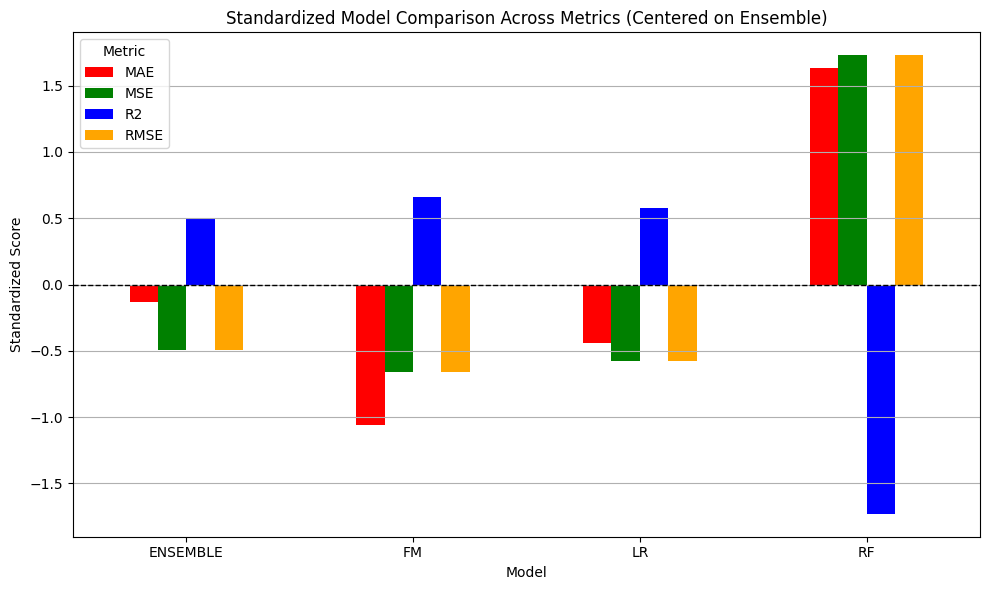

In [20]:
# Standardize scores per metric using z-score, centered by ensemble
from sklearn.preprocessing import StandardScaler

pivot_df = results_df.pivot(index="Model", columns="Metric", values="Score")
# For RMSE, MSE, MAE we invert so lower is better; R2 stays as-is
for col in ["RMSE", "MSE", "MAE"]:
    pivot_df[col] = -pivot_df[col]

# Standardize with respect to each metric
scaler = StandardScaler()
pivot_scaled = pd.DataFrame(scaler.fit_transform(pivot_df), columns=pivot_df.columns, index=pivot_df.index)

# Revert sign for visualization (higher is better again)
for col in ["RMSE", "MSE", "MAE"]:
    pivot_scaled[col] = -pivot_scaled[col]

# Plot all metrics in one standardized grouped bar plot
pivot_scaled.plot(kind='bar', figsize=(10, 6), color=["red", "green", "blue", "orange"], rot=0)
plt.title("Standardized Model Comparison Across Metrics (Centered on Ensemble)")
plt.ylabel("Standardized Score")
plt.xlabel("Model")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title="Metric")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [27]:
# Fixed weights: 0.5 for LR, 0.5 for FM
# Fixed weights: 0.5 for LR, 0.5 for FM (RF excluded)
w_lr = 0.5
w_fm = 0.5
print(f"Using fixed weights -> LR: {w_lr:.3f}, FM: {w_fm:.3f}")


ensemble_df = ensemble_df.withColumn("ensemble_pred", expr(f"({w_lr} * lr_pred + {w_fm} * fm_pred)"))

# Evaluate ensemble only
metrics = ["rmse", "mse", "mae", "r2"]
results = []
evaluators = {m: RegressionEvaluator(labelCol=label_col, predictionCol="ensemble_pred", metricName=m) for m in metrics}

for metric in metrics:
    score = evaluators[metric].evaluate(ensemble_df)
    results.append(("ENSEMBLE", metric.upper(), score))

# Convert to pandas for plotting
results_df = pd.DataFrame(results, columns=["Model", "Metric", "Score"])
print(results_df)

Using fixed weights -> LR: 0.500, FM: 0.500
      Model Metric     Score
0  ENSEMBLE   RMSE  0.053561
1  ENSEMBLE    MSE  0.002869
2  ENSEMBLE    MAE  0.016428
3  ENSEMBLE     R2  0.000881


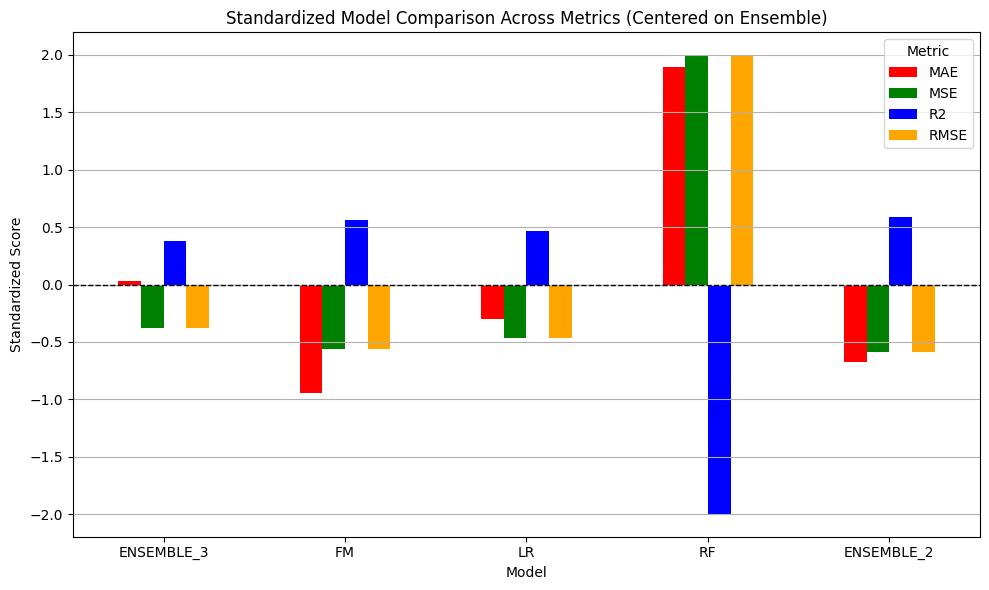

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Combine both ensemble sets and all models into one DataFrame
data = {
    "Model": ["ENSEMBLE_3", "FM", "LR", "RF", "ENSEMBLE_2"],
    "MAE": [0.016924, 0.016234, 0.016693, 0.018246, 0.016428],
    "MSE": [0.002888, 0.002871, 0.002880, 0.003107, 0.002869],
    "R2":  [-0.005691, -0.000024, -0.002972, -0.082039, 0.000881],
    "RMSE":[0.053736, 0.053585, 0.053664, 0.055739, 0.053561]
}

# Convert to DataFrame
results_df = pd.DataFrame(data)
results_df = results_df.set_index("Model")

# Invert error metrics so that higher is better for standardization
pivot_df = results_df.copy()
for col in ["RMSE", "MSE", "MAE"]:
    pivot_df[col] = -pivot_df[col]

# Apply StandardScaler
scaler = StandardScaler()
pivot_scaled = pd.DataFrame(scaler.fit_transform(pivot_df), columns=pivot_df.columns, index=pivot_df.index)

# Revert inversion for visual clarity (higher is better)
for col in ["RMSE", "MSE", "MAE"]:
    pivot_scaled[col] = -pivot_scaled[col]

# Plot
ax = pivot_scaled.plot(kind='bar', figsize=(10, 6), color=["red", "green", "blue", "orange"], rot=0)
plt.title("Standardized Model Comparison Across Metrics (Centered on Ensemble)")
plt.ylabel("Standardized Score")
plt.xlabel("Model")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title="Metric")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
